In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast
from collections import defaultdict
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from random import shuffle
from sklearn.decomposition import PCA

In [6]:
def parseData(fname):
    for l in open(fname):
        yield ast.literal_eval(l)

In [7]:
userData=list(parseData("yelp_dataset/yelp_academic_dataset_user.json"))

In [8]:
tipData=list(parseData("yelp_dataset/yelp_academic_dataset_tip.json"))

In [9]:
reviewData=list(parseData("yelp_dataset/yelp_academic_dataset_review.json"))

In [10]:
eliteIDs = []
for u in userData:
    if not 'None' in u['elite']:
        eliteIDs.append(u["user_id"])

In [ ]:
# BASELINE: Predicting not-elite for every user
predictions = [0 for u in userData]
correct = (predictions == df["elite"])
print(sum(correct) / len(correct))

In [ ]:
# BASELINE #2: Usin closeness to elite vs non-elite averages
eReviews = []
nReviews = []
eFriends = []
nFriends = []
eCompliments = []
nCompliments = []
eVotes = []
nVotes = []
for i, row in df.iterrows():
    if row["elite"] == 0:
        nReviews.append(row["numReviews"])
        nFriends.append(row["numFriends"])
        nCompliments.append(row["numCompliments"])
        nVotes.append(row["numVotes"])
    else:
        eReviews.append(row["numReviews"])
        eFriends.append(row["numFriends"])
        eCompliments.append(row["numCompliments"])
        eVotes.append(row["numVotes"])
eReviewsAvg = np.mean(eReviews)
nReviewsAvg = np.mean(nReviews)
eFriendsAvg = np.mean(eFriends)
nFriendsAvg = np.mean(nFriends)
eComplimentsAvg = np.mean(eCompliments)
nComplimentsAvg = np.mean(nCompliments)
eVotesAvg = np.mean(eVotes)
nVotesAvg = np.mean(nVotes)

In [ ]:
def findCloserAvg(user_avg, elite_avg, non_elite_avg):
    mid = (elite_avg + non_elite_avg) / 2
    if user_avg >= mid:
        return 1
    else:
        return 0

In [ ]:
points = []
for i,row in df.iterrows():
    point = 0
    if findCloserAvg(row["numReviews"], eReviewsAvg, nReviewsAvg):
        point += 1
    if findCloserAvg(row["numFriends"], eFriendsAvg, nFriendsAvg):
        point += 1
    if findCloserAvg(row["numCompliments"], eComplimentsAvg, nComplimentsAvg):
        point += 1
    if findCloserAvg(row["numVotes"], eVotesAvg, nVotesAvg):
        point += 1
    points.append(point)

In [ ]:
pre = []
for p in points:
    if p == 4:
        pre.append(1)
    else:
        pre.append(0)
print(mean_squared_error(df["elite"], pre))
print(accuracy_score(df["elite"], pre))

## Using Only the User Data

In [11]:
def apr(yhat, true, threshold):
    predictions = (yhat > threshold)
    correct = (predictions == true)
    truepos, trueneg, falsepos, falseneg = 0,0,0,0
    for (a,b) in zip(predictions, true):
        if a==True and b==True:
            truepos+=1
        elif a==False and b==False:
            trueneg+=1
        elif a==True and b==False:
            falsepos+=1
        else:
            falseneg+=1
    acc = sum(correct) / len(correct)
    precision = truepos / (truepos + falsepos)
    recall = truepos / (truepos + falseneg)
    return acc, precision, recall

In [12]:
def sumCompliments(user):
    compliment_count = user["compliment_hot"] + user["compliment_more"]
    + user["compliment_profile"] + user["compliment_cute"] + user["compliment_list"]
    + user["compliment_note"] + user["compliment_plain"] + user["compliment_cool"]
    + user["compliment_funny"] + user["compliment_writer"] + user["compliment_photos"]
    return compliment_count

In [13]:
def sumVotes(user):
    useful = user['useful']
    funny = user['funny']
    cool = user['cool']
    return useful + funny + cool

In [14]:
numReviews = []
numCompliments = []
numVotes = []
numAvgRatings = []
numFans = []
numFriends = []
elite = []
for u in userData:
    numReviews.append(u["review_count"])
    numCompliments.append(sumCompliments(u))
    numVotes.append(sumVotes(u))
    numAvgRatings.append(u["average_stars"])
    numFans.append(u["fans"])
    
    if 'None' in u['friends']:
        numFriends.append(0)
    else:
        numFriends.append(len(u['friends'].split(", ")))
    
    if not 'None' in u['elite']:
        elite.append(1)
    else:
        elite.append(0)

In [115]:
df = pd.DataFrame()
df['numReviews'] = numReviews
df['numFriends'] = numFriends
df['numCompliments'] = numCompliments
df['numVotes'] = numVotes
df['numFans'] = numFans
df['numAvgRatings'] = numAvgRatings
df['elite'] = elite

In [ ]:
df.boxplot(by=["elite"], column=["numReviews"], showfliers=False)

In [ ]:
df.boxplot(by=["elite"], column=["numFriends"], showfliers=False)

In [ ]:
df.boxplot(by=["elite"], column=["numCompliments"], showfliers=False)

In [ ]:
df.boxplot(by=["elite"], column=["numVotes"], showfliers=False)

In [ ]:
df.boxplot(by=["elite"], column=["numFans"], showfliers=False)

In [ ]:
df.boxplot(by=["elite"], column=["numAvgRatings"])

Looks like most of these features will be able to pretty accurately predict eliteness since the boxplots between elite and non-elite are quite different. For number of average ratings the values are similar but the variance is not.

In [16]:
def log_normalization(val):
    if val > 0:
        return np.log(val)
    else:
        return np.log(val + .001)

In [17]:
df_init = df.copy()
for d in df:
    if d == 'numAvgRatings' or d == 'elite':
        continue
    df[d] = df[d].apply(log_normalization)

In [ ]:
mse1=[]
for d in df:
    if d == 'elite':
        break
    formula = 'elite ~ ' + d
    model=smf.logit(formula, data=df).fit(disp=0)
    yhat1 = model.predict(df[d])
    mse1.append(mean_squared_error(df["elite"], yhat1))
    print(model.summary())
print(mse1)

In [ ]:
features = ['numReviews', 'numFriends', 'numCompliments', 'numVotes', 'numFans', 'numAvgRatings']
plt.scatter(features,mse1)
plt.xlabel("Feature")
plt.ylabel("Mean Squared Error")
plt.title("MSE of Each User Feature Separately")

In [ ]:
mse2=[]
for d in df:
    if d == 'elite' or d == 'numReviews':
        continue
    formula = 'elite ~ numReviews + ' + d
    model=smf.logit(formula, data=df).fit()
    yhat2 = model.predict(df[['numReviews', d]])
    mse2.append(mean_squared_error(df["elite"], yhat2))
print(mse2)

In [ ]:
plt.scatter(features[1:],mse2)
plt.xlabel("Feature")
plt.ylabel("Mean Squared Error")
plt.title("MSE of the Lowest MSE Feature (numReviews) and One Other Feature")
plt.ylim((0.022, 0.023)) 

In [ ]:
mse3=[]
for d in df:
    if d == 'elite' or d == 'numReviews' or d == 'numFriends':
        continue
    formula = 'elite ~ numReviews + numFriends + ' + d
    model=smf.logit(formula, data=df).fit()
    yhat3 = model.predict(df[['numReviews', 'numFriends', d]])
    mse3.append(mean_squared_error(df["elite"], yhat3))
print(mse3)

In [ ]:
plt.scatter(features[2:],mse3)
plt.xlabel("Feature")
plt.ylabel("Mean Squared Error")
plt.title("MSE of the 2 Lowest MSE Features (numReviews, numFriends) and One Other Feature")
plt.ylim((0.0218, 0.0222))

In [ ]:
mse4=[]
for d in df:
    if d == 'elite' or d == 'numReviews' or d == 'numFriends' or d == 'numAvgRatings':
        continue
    formula = 'elite ~ numReviews + numFriends + numAvgRatings + ' + d
    model=smf.logit(formula, data=df).fit()
    yhat4 = model.predict(df[['numReviews', 'numFriends', 'numAvgRatings', d]])
    mse4.append(mean_squared_error(df["elite"], yhat4))
print(mse4)

In [ ]:
plt.scatter(features[2:4],mse4)
plt.xlabel("Feature")
plt.ylabel("Mean Squared Error")
plt.title("MSE of the 3 Lowest MSE Features (numReviews, numFriends, numAvgRatings) and One Other Feature")
plt.ylim((0.0218, 0.022))

In [ ]:
features = ['numReviews', 'numFriends', 'numCompliments', 'numVotes', 'numFans', 'numAvgRatings']
formula = 'elite ~ numReviews + numFriends + numAvgRatings + numCompliments + numVotes + numFans'
model=smf.logit(formula, data=df).fit(disp=0)
yhat6 = model.predict(df[features])
mse6 = mean_squared_error(df["elite"], yhat6)
print(model.summary())

In [ ]:
print(mse6)
print(apr(yhat6, df["elite"], 0.4))

In [118]:
mse_train = []
acc_train = []
prec_train = []
rec_train = []
mse_test = []
acc_test = []
prec_test = []
rec_test = []
features = ['numReviews', 'numFriends', 'numCompliments', 'numVotes', 'numFans', 'numAvgRatings']
formula = 'elite ~ numReviews + numFriends + numAvgRatings + numCompliments + numVotes + numFans'
kf = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(df):
    df_train = df.iloc[train_index, :]
    df_test = df.iloc[test_index, :]
    mod = smf.logit(formula, data=df_train).fit(disp=0)
    yhat_train = mod.predict(df_train[features])
    mse_train.append(mean_squared_error(df_train["elite"], yhat_train))
    a,p,r = apr(yhat_train, df_train["elite"], 0.4)
    acc_train.append(a)
    prec_train.append(p)
    rec_train.append(r)
    yhat_test = mod.predict(df_test[features])
    mse_test.append(mean_squared_error(df_test["elite"], yhat_test))
    a,p,r = apr(yhat_test, df_test["elite"], 0.4)
    acc_test.append(a)
    prec_test.append(p)
    rec_test.append(r)
print("The average training error is " + str(np.mean(mse_train)))
print("The average training accuracy is " + str(np.mean(acc_train)))
print("The average training precision is " + str(np.mean(prec_train)))
print("The average training recall is " + str(np.mean(rec_train)))
print("The average testing error is " + str(np.mean(mse_test)))
print("The average testing accuracy is " + str(np.mean(acc_test)))
print("The average testing precision is " + str(np.mean(prec_test)))
print("The average testing recall is " + str(np.mean(rec_test)))

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The average training error is 0.021246933040634332
The average training accuracy is 0.9730928067529423
The average training precision is 0.773796932186886
The average training recall is 0.5529305292375987
The average testing error is 0.021249534602802825
The average testing accuracy is 0.9730886351533445
The average testing precision is 0.773793300515453
The average testing recall is 0.5528238160934649


I wanted to see if the features used would be redundant at some point, and used a forward stepwise selection to choose the best features one by one. However in this case, the model with the lowest MSE and best accuracy still ended up being the one using all the features, which I guess makes sense and is okay since we only have 5 features total here. I used K-fold cross validation to check that the testing error and accuracy wouldn't be wildly different from training, which is wasn't. I chose 0.3 for the accuracy threshold since that seemed to produce the best results.

## Some Extra Friend Data

In [18]:
eliteIDs = set(eliteIDs)

In [19]:
sumEliteFriends = []
ratioEliteFriends = []
for u in userData:
    if not 'None' in u['friends']:
        friends = u['friends'].split(", ")
        sumE = 0
        for f in friends:
            if f in eliteIDs:
                sumE += 1
        sumEliteFriends.append(sumE)
        ratioEliteFriends.append(sumE * 1.0/len(friends))
    else:
        sumEliteFriends.append(0)
        ratioEliteFriends.append(0)

In [20]:
df["sumEliteFriends"] = sumEliteFriends
df["ratioEliteFriends"] = ratioEliteFriends
df["sumEliteFriends"]=df["sumEliteFriends"].apply(log_normalization)

In [ ]:
features = ['numReviews', 'numFriends', 'numCompliments', 'numVotes', 'numFans', 'numAvgRatings', 'sumEliteFriends', 'ratioEliteFriends']
formula = 'elite ~ numReviews + numFriends + numAvgRatings + numCompliments + numVotes + numFans + sumEliteFriends + ratioEliteFriends'
mse_train = []
acc_train = []
prec_train = []
rec_train = []
mse_test = []
acc_test = []
prec_test = []
rec_test = []
kf = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(df):
    df_train = df.iloc[train_index, :]
    df_test = df.iloc[test_index, :]
    mod = smf.logit(formula, data=df_train).fit(disp=0)
    yhat_train = mod.predict(df_train[features])
    mse_train.append(mean_squared_error(df_train["elite"], yhat_train))
    a,p,r = apr(yhat_train, df_train["elite"], 0.4)
    acc_train.append(a)
    prec_train.append(p)
    rec_train.append(r)
    yhat_test = mod.predict(df_test[features])
    mse_test.append(mean_squared_error(df_test["elite"], yhat_test))
    a,p,r = apr(yhat_test, df_test["elite"], 0.4)
    acc_test.append(a)
    prec_test.append(p)
    rec_test.append(r)
print("The average training error is " + str(np.mean(mse_train)))
print("The average training accuracy is " + str(np.mean(acc_train)))
print("The average training precision is " + str(np.mean(prec_train)))
print("The average training recall is " + str(np.mean(rec_train)))
print("The average testing error is " + str(np.mean(mse_test)))
print("The average testing accuracy is " + str(np.mean(acc_test)))
print("The average testing precision is " + str(np.mean(prec_test)))
print("The average testing recall is " + str(np.mean(rec_test)))

In [ ]:
print(mod.summary())

## Using Tip Data

In [21]:
tipCounts = defaultdict(int)
tipLikes = defaultdict(int)
for t in tipData:
    tipCounts[t["user_id"]] += 1
    tipLikes[t["user_id"]] += t["likes"]

In [22]:
numTips = []
numTipLikes = []
numTipRatio = []
for u in userData:
    if u["user_id"] in tipCounts:
        numTips.append(tipCounts[u["user_id"]])
        numTipLikes.append(tipLikes[u["user_id"]])
        if tipLikes[u["user_id"]] > 0:
            numTipRatio.append(tipLikes[u["user_id"]]/(tipCounts[u["user_id"]]*1.0))
        else:
            numTipRatio.append(0)
    else:
        numTips.append(0)
        numTipLikes.append(0)
        numTipRatio.append(0)

In [23]:
df['numTips'] = numTips
df['numTipLikes'] = numTipLikes
df['numTipRatio'] = numTipRatio

In [24]:
df['numTips'] = df['numTips'].apply(log_normalization)
df['numTipLikes'] = df['numTipLikes'].apply(log_normalization)

In [ ]:
mse1_tip = []
acc1_tip = []
for d in df:
    if d == "numTips" or d == "numTipLikes" or d == "numTipRatio":
        formula = 'elite ~ ' + d
        model=smf.logit(formula, data=df).fit(disp=0)
        yhat1_tip = model.predict(df[d])
        mse1_tip.append(mean_squared_error(df_tip["elite"], yhat1_tip))
        acc1_tip.append(accuracy(yhat1_tip, df_tip["elite"], 0.3))
        print(model.summary())
print(mse1_tip)
print(acc1_tip)

In [ ]:
formula = 'elite ~ numTips + numTipLikes + numTipRatio'
model=smf.logit(formula, data=df).fit(disp=0)
yhat_tip = model.predict(df[['numTips', 'numTipLikes', 'numTipRatio']])
mse_tip = mean_squared_error(df["elite"], yhat_tip)
print(mse_tip)
print(model.summary())

The tip data gives us a slight edge over baseline, but not by much. The feature set with the highest accuracy was numTipLikes. We'll test this out on top of the user features.

In [ ]:
features = ['numReviews', 'numFriends', 'numCompliments', 'numVotes', 'numFans', 'numAvgRatings', 'sumEliteFriends', 'ratioEliteFriends', 'numTips']
formula = 'elite ~ numReviews + numFriends + numAvgRatings + numCompliments + numVotes + numFans + sumEliteFriends + ratioEliteFriends + numTips'
mse_train = []
acc_train = []
prec_train = []
rec_train = []
mse_test = []
acc_test = []
prec_test = []
rec_test = []
kf = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(df):
    df_train = df.iloc[train_index, :]
    df_test = df.iloc[test_index, :]
    mod = smf.logit(formula, data=df_train).fit(disp=0)
    yhat_train = mod.predict(df_train[features])
    mse_train.append(mean_squared_error(df_train["elite"], yhat_train))
    a,p,r = apr(yhat_train, df_train["elite"], 0.4)
    acc_train.append(a)
    prec_train.append(p)
    rec_train.append(r)
    yhat_test = mod.predict(df_test[features])
    mse_test.append(mean_squared_error(df_test["elite"], yhat_test))
    a,p,r = apr(yhat_test, df_test["elite"], 0.4)
    acc_test.append(a)
    prec_test.append(p)
    rec_test.append(r)
print("The average training error is " + str(np.mean(mse_train)))
print("The average training accuracy is " + str(np.mean(acc_train)))
print("The average training precision is " + str(np.mean(prec_train)))
print("The average training recall is " + str(np.mean(rec_train)))
print("The average testing error is " + str(np.mean(mse_test)))
print("The average testing accuracy is " + str(np.mean(acc_test)))
print("The average testing precision is " + str(np.mean(prec_test)))
print("The average testing recall is " + str(np.mean(rec_test)))

The average training error is 0.015613125660818766

The average training accuracy is 0.9779664407198752

The average training precision is 0.7463867836734787

The average training recall is 0.759676340163405

The average testing error is 0.01561444227434231

The average testing accuracy is 0.9779635867222914

The average testing precision is 0.7463717417074281

The average testing recall is 0.7596678473660

0.7152

In [ ]:
print(mod.summary())

## Using Rating Data

In [25]:
reviewLengths = defaultdict(list)
reviewUsefuls = defaultdict(int)
reviewFunnys = defaultdict(int)
reviewCools = defaultdict(int)
reviewParagraphs = defaultdict(int)
reviewBullets = defaultdict(int)
reviewProCon = defaultdict(int)
reviewColons = defaultdict(int)
for r in reviewData:
    reviewLengths[r["user_id"]].append(len(r["text"]))
    reviewUsefuls[r["user_id"]] += r["useful"]
    reviewFunnys[r["user_id"]] += r["funny"]
    reviewCools[r["user_id"]] += r["cool"]
    
    if "\n" in r["text"]:
        reviewParagraphs[r["user_id"]] += 1
    if "-" in r["text"] or "1." in r["text"] or "1)" in r["text"]:
        reviewBullets[r["user_id"]] += 1
    if "Pros" in r["text"] or "Cons" in r["text"] or "PROS" in r["text"] or "CONS" in r["text"] or "Pro" in r["text"] or "Con" in r["text"]:
        reviewProCon[r["user_id"]] += 1
    if ":" in r["text"]:
        reviewColons[r["user_id"]] += 1

In [26]:
avgLength = []
numUsefuls = []
numFunnys = []
numCools = []
numParagraphs = []
numBullets = []
numProCon = []
numColons = []
for u in userData:
    if u["user_id"] in reviewLengths:
        avgLength.append(sum(reviewLengths[u["user_id"]])/len(reviewLengths[u["user_id"]]))
        numUsefuls.append(reviewUsefuls[u["user_id"]])
        numFunnys.append(reviewFunnys[u["user_id"]])
        numCools.append(reviewCools[u["user_id"]])

        if reviewParagraphs[u["user_id"]]:
            numParagraphs.append(reviewParagraphs[u["user_id"]])
        else:
            numParagraphs.append(0)
            
        if reviewBullets[u["user_id"]]:
            numBullets.append(reviewBullets[u["user_id"]])
        else:
            numBullets.append(0)
            
        if reviewProCon[u["user_id"]]:
            numProCon.append(reviewProCon[u["user_id"]])
        else:
            numProCon.append(0)
            
        if reviewColons[u["user_id"]]:
            numColons.append(reviewColons[u["user_id"]])
        else:
            numColons.append(0)
    else:
        avgLength.append(0)
        numUsefuls.append(0)
        numFunnys.append(0)
        numCools.append(0)
        numParagraphs.append(0)
        numBullets.append(0)
        numProCon.append(0)
        numColons.append(0)

In [27]:
df['avgLength'] = avgLength
df['numUsefuls'] = numUsefuls
df['numFunnys'] = numFunnys
df['numCools'] = numCools
df['numParagraphs'] = numParagraphs
df['numBullets'] = numBullets
df['numProCon'] = numProCon
df['numColons'] = numColons

In [28]:
df['avgLength'] = df['avgLength'].apply(log_normalization)
df['numUsefuls'] = df['numUsefuls'].apply(log_normalization)
df['numFunnys'] = df['numFunnys'].apply(log_normalization)
df['numCools'] = df['numCools'].apply(log_normalization)
df['numParagraphs'] = df['numParagraphs'].apply(log_normalization)
df['numBullets'] = df['numBullets'].apply(log_normalization)
df['numProCon'] = df['numProCon'].apply(log_normalization)
df['numColons'] = df['numColons'].apply(log_normalization)

In [ ]:
features = ['avgLength', 'numUsefuls', 'numFunnys', 'numCools', 'numParagraphs', 'numBullets', 'numProCon', 'numColons']
for d in df:
    if d in features:
        formula = 'elite ~ ' + d
        model=smf.logit(formula, data=df).fit(disp=0)
        yhat1_rev = model.predict(df[d])
        print(model.summary())

In [ ]:
features = ['numReviews', 'numFriends', 'numCompliments', 'numVotes', 'numFans', 'numAvgRatings', 'sumEliteFriends', 'numTipLikes','avgLength','numUsefuls','numFunnys','numCools','numParagraphs','numBullets']
formula = 'elite ~ numReviews + numFriends + numCompliments + numVotes + numFans + numAvgRatings + sumEliteFriends + numTipLikes + avgLength + numUsefuls + numFunnys + numCools + numParagraphs + numBullets'
model=smf.logit(formula, data=df).fit(disp=0)
yhat_rev = model.predict(df[features])
mse_rev = mean_squared_error(df["elite"], yhat_rev)
print(mse_rev)
a,p,r = (apr(yhat_rev, df["elite"], 0.4))
print(a)
print(p)
print(r)

In [ ]:
print(model.summary())

In [ ]:
numTotalVotes = []
for a,b,c in zip(numUsefuls, numFunnys, numCools):
    numTotalVotes.append(a+b+c)
df_rev['numTotalVotes'] = numTotalVotes

In [ ]:
formula = 'elite ~ + numTotalVotes'
model=smf.logit(formula, data=df_rev).fit(disp=0)
yhatT_rev = model.predict(df_rev['numTotalVotes'])
print(mean_squared_error(df_rev["elite"], yhatT_rev))
print(accuracy(yhatT_rev, df_rev["elite"], 0.3))
print(model.summary())

In [ ]:
## Using all new features:
## 0.03576745709167296
## 0.9593661838701751

## Using only the vote (Useful/Funny/Cool) features:
## 0.036733024586753496
## 0.9598404393713743

## Using only the review text (Paragraphs/Bullets/ProCon/Colons) features:
## 0.037157969461905554
## 0.9586475550482193

It looks like the best feature set out of the reviews to use is using Number of Cool Votes and Number of Funny Votes. We'll add this to our user and tip features to see if we can get the accuracy better.

In [ ]:
features = ['numReviews', 'numFriends', 'numCompliments', 'numVotes', 'numFans', 'numAvgRatings', 'sumEliteFriends', 'numTipLikes','avgLength','numUsefuls','numFunnys','numCools','numParagraphs','numBullets']
formula = 'elite ~ numReviews + numFriends + numCompliments + numVotes + numFans + numAvgRatings + sumEliteFriends + numTipLikes + avgLength + numUsefuls + numFunnys + numCools + numParagraphs + numBullets'
mse_train = []
acc_train = []
prec_train = []
rec_train = []
mse_test = []
acc_test = []
prec_test = []
rec_test = []
kf = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(df):
    df_train = df.iloc[train_index, :]
    df_test = df.iloc[test_index, :]
    mod = smf.logit(formula, data=df_train).fit(disp=0)
    yhat_train = mod.predict(df_train[features])
    mse_train.append(mean_squared_error(df_train["elite"], yhat_train))
    a,p,r = apr(yhat_train, df_train["elite"], 0.4)
    acc_train.append(a)
    prec_train.append(p)
    rec_train.append(r)
    yhat_test = mod.predict(df_test[features])
    mse_test.append(mean_squared_error(df_test["elite"], yhat_test))
    a,p,r = apr(yhat_test, df_test["elite"], 0.4)
    acc_test.append(a)
    prec_test.append(p)
    rec_test.append(r)
print("The average training error is " + str(np.mean(mse_train)))
print("The average training accuracy is " + str(np.mean(acc_train)))
print("The average training precision is " + str(np.mean(prec_train)))
print("The average training recall is " + str(np.mean(rec_train)))
print("The average testing error is " + str(np.mean(mse_test)))
print("The average testing accuracy is " + str(np.mean(acc_test)))
print("The average testing precision is " + str(np.mean(prec_test)))
print("The average testing recall is " + str(np.mean(rec_test)))

In [ ]:
print(mod.summary())

## Using SVM Instead of Logistic Regression

In [29]:
features = ['numReviews', 'numFriends', 'numCompliments', 'numVotes', 'numFans', 'numAvgRatings', 'sumEliteFriends', 'numTipLikes','avgLength','numUsefuls','numFunnys','numCools','numParagraphs','numBullets']

In [30]:
def feature(d):
    feat = []
    for f in features:
        feat.append(d[f])
    return feat

In [31]:
selected_df = df[features].copy()
selected_df["elite"] = df["elite"]

In [32]:
elite_df = selected_df[selected_df['elite'] == 1]
nonelite_df = selected_df[selected_df['elite'] == 0]

In [33]:
smaller_elite = elite_df.head(25000)
smaller_nonelite = nonelite_df.head(25000)

In [34]:
smaller_df = pd.DataFrame()
smaller_df = smaller_df.append(smaller_elite)
smaller_df = smaller_df.append(smaller_nonelite)
len(smaller_df)

50000

In [35]:
shuffled_df = smaller_df.sample(frac=1)

In [36]:
X = [feature(row) for i,row in shuffled_df.iterrows()]
y = [row['elite'] for i,row in shuffled_df.iterrows()]

In [37]:
X_train = X[:len(shuffled_df)//2]
y_train = y[:len(shuffled_df)//2]
X_test = X[len(shuffled_df)//2:]
y_test = y[len(shuffled_df)//2:]

In [38]:
clf = svm.SVC(C=1000, kernel='sigmoid')
clf.fit(X_train, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [122]:
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

In [126]:
correct_train = (train_predictions == y_train)
correct_test = (test_predictions == y_test)
trainAcc = sum(correct_train) / len(correct_train)
print("Training accuracy was " + str(trainAcc))
testAcc = sum(correct_test) / len(correct_test)
print("Test accuracy was " + str(testAcc))

Training accuracy was 0.62424
Test accuracy was 0.63264


In [127]:
print(mean_squared_error(y_test, test_predictions))

0.36736


In [125]:
truepos, trueneg, falsepos, falseneg = 0,0,0,0
for (a,b) in zip(test_predictions, y_test):
    if a==True and b==True:
        truepos+=1
    elif a==False and b==False:
        trueneg+=1
    elif a==True and b==False:
        falsepos+=1
    else:
        falseneg+=1
precision = truepos / (truepos + falsepos)
recall = truepos / (truepos + falseneg)
print(precision)
print(recall)

0.6372612495953383
0.6261132315521628


## PCA for Feature Importance

In [43]:
feature_df = df.drop(columns=['elite'])

In [46]:
stds = []
for d in feature_df:
    stds.append(np.std(feature_df[d]))

In [47]:
i=0
for d in feature_df:
    feature_df[d] = feature_df[d] / stds[i]
    i=i+1

In [52]:
pca = PCA(n_components=19)
principalComponents = pca.fit_transform(feature_df)

In [53]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19'])

In [56]:
principalDf["elite"] = df["elite"]
mse_train = []
mse_test = []
formula = 'elite ~ '
k_used = []
for k in principalDf:
    if k == 'elite':
        break
    if not k_used:
        formula = formula + k
    else:
        formula = formula + " + " + k
    k_used.append(k)
    
    this_mse_train = []
    this_mse_test = []
    kf_col = k_used.copy()
    kf_col.append('elite')
    df = principalDf[kf_col]
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(df):
        df_train = df.iloc[train_index, :]
        df_test = df.iloc[test_index, :]
        mod = smf.logit(formula, data=df_train).fit()
        yhat_train = mod.predict(df_train[k_used])
        this_mse_train.append(mean_squared_error(df_train["elite"], yhat_train))
        yhat_test = mod.predict(df_test[k_used])
        this_mse_test.append(mean_squared_error(df_test["elite"], yhat_test))
    mse_train.append(np.mean(this_mse_train))
    mse_test.append(np.mean(this_mse_test))

Optimization terminated successfully.
         Current function value: 0.091643
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.091648
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.090567
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.084070
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.083222
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.082459
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.082014
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.081351
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.081000
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.080961
  

Optimization terminated successfully.
         Current function value: 0.062255
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.062257
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.061409
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.056610
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.056125
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.055499
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.055226
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.054662
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.054448
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.060243
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.060272
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.059430
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.054799
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.054348
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.053724
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.053470
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.052932
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.052716
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.

Text(0.5,1,'Training and Testing MSE for Different #s of PCS')

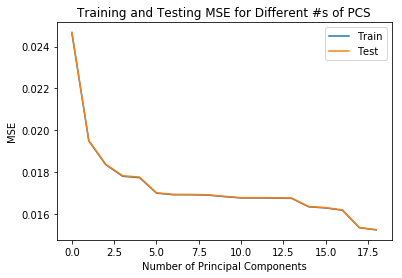

In [60]:
plt.plot(mse_train, label="Train")
plt.plot(mse_test, label="Test")
plt.legend()
plt.xlabel("Number of Principal Components")
plt.ylabel("MSE")
plt.title("Training and Testing MSE for Different #s of PCS")

In [76]:
m = feature_df.columns.values

In [72]:
r = [0.6377,0.2536,0.4974,0.3832,0.5476,0.002275,0.5460,0.1193,0.02428,0.01398,0.0014,0.06551,0.1235,0.1374,0.1786,0.1477,0.1183,0.05768,0.09875]

In [74]:
metrics = pd.DataFrame({"Metric": m, "R-Squared": r})

In [80]:
metrics = metrics.sort_values('R-Squared', ascending=False)

In [119]:
metrics["Type"] = [1,1,2,1,1,1,4,4,4,4,2,4,4,4,4,3,3,1,3]

In [102]:
from matplotlib.lines import Line2D

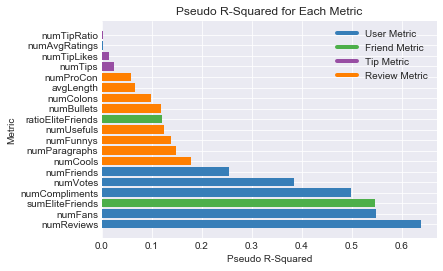

In [113]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
plt.barh(metrics["Metric"], metrics["R-Squared"], color=palette(metrics["Type"]))
plt.xlabel("Pseudo R-Squared")
plt.ylabel("Metric")
plt.title("Pseudo R-Squared for Each Metric")
custom_lines = [Line2D([0], [0], color=palette(1), lw=4),
                Line2D([0], [0], color=palette(2), lw=4),
                Line2D([0], [0], color=palette(3), lw=4),
                Line2D([0], [0], color=palette(4), lw=4)]
label = ["User Metric", "Friend Metric", "Tip Metric", "Review Metric"]
plt.legend(custom_lines, label)
plt.show()